<a href="https://colab.research.google.com/github/mohammedterry/NLP_for_ML/blob/master/Sentence_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
example_sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
    
    # Cats and Dogs
    "Cats chase dogs",
    "Dogs chase cats",
]

In [0]:
def most_similar(vector, other_vectors):
  from scipy.spatial.distance import cosine

  scores = [cosine(vector, vec) for vec in other_vectors]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
  return ranked_candidates

In [0]:
def plot_sentences(sentences, svectors):
  %matplotlib inline
  from sklearn.decomposition import PCA
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(svectors)

  import pandas as pd
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y'])
    
  import seaborn as sns    
  graph=sns.regplot(data=dataframe, x="x", y="y", fit_reg=False, marker="+")
  [graph.text(x, y, s) for x,y,s in zip(dataframe['x'],dataframe['y'],sentences)]

In [0]:
def plot3D_sentences(sentences, svectors):
  %matplotlib inline
  from sklearn.decomposition import PCA
  pca = PCA(n_components=3)
  principalComponents = pca.fit_transform(svectors)
  
  import pandas as pd
  dataframe = pd.DataFrame(data = principalComponents, columns = ['x', 'y','z'])
  
  import matplotlib.pyplot as plt, mpl_toolkits.mplot3d
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  for x, y, z, s in zip(dataframe['x'], dataframe['y'], dataframe['z'], sentences):
      ax.text(x, z, y, s, 'x')
  ax.set_xlim(min(dataframe['x']), max(dataframe['x']))
  ax.set_ylim(min(dataframe['z']), max(dataframe['z']))
  ax.set_zlim(min(dataframe['y']), max(dataframe['y']))
  plt.show()

# One-hot encodings
* method: assign each word in the sentence to a dimension in the vector 
* pros: simple
* cons: doesn't preserve word order nor cope with sentences with identical meanings and different words, or identical words and different meanings

In [0]:
from gensim.corpora import Dictionary
bows = Dictionary([sentence.lower().split() for sentence in example_sentences])

def bow_vectoriser(sentences):
  bow_features = [bows.doc2bow(sentence.lower().split()) for sentence in sentences]
  vec_len = len(bows)
  idxs = [[v[0] for v in vector ] for vector in bow_features]
  return [[1 if i in idx else 0 for i in range(vec_len)] for idx in idxs]

In [0]:
bow_vectors = bow_vectoriser(example_sentences)

In [0]:
most_similar(bow_vectoriser(["i like my cell phone"])[0], bow_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

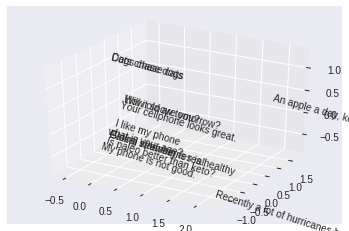

In [0]:
plot3D_sentences(example_sentences, bow_vectors)

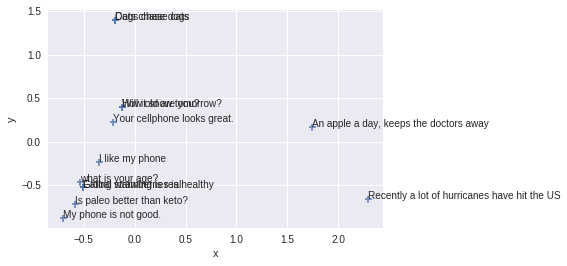

In [0]:
plot_sentences(example_sentences, bow_vectors)

# Doc2Vec

In [0]:
import gensim

topics = [0]*3 + [1]*3 + [2]*3 + [3]*2 + [4]*2
d2v_sentences = [gensim.models.doc2vec.TaggedDocument(sentence.lower().split(),[topic]) for topic,sentence in zip(topics,example_sentences)]
doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
doc2vec.build_vocab(d2v_sentences)
doc2vec.train(d2v_sentences, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

2019-03-12 23:20:53,795 consider setting layer size to a multiple of 4 for greater performance


In [0]:
d2v_vectors = [doc2vec.infer_vector(sentence.lower().split()) for sentence in example_sentences]

In [0]:
most_similar(doc2vec.infer_vector("i like my cell phone".split()), d2v_vectors)

['Your cellphone looks great.', 'Cats chase dogs', 'I like my phone']

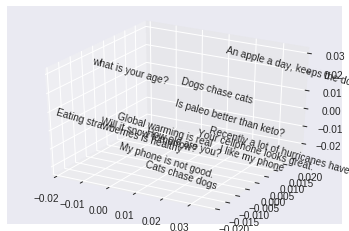

In [0]:
plot3D_sentences(example_sentences, d2v_vectors)

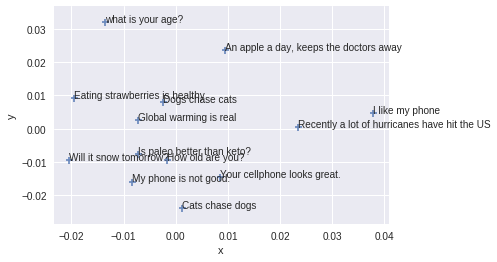

In [0]:
plot_sentences(example_sentences, d2v_vectors)

# Char2Vec

* Idea:  Convert the sentence (string of characters) into a fixed-size vector (150 dimensions) according to the sequence of characters in its string (takes character order into account).
* Pros:  Relatively Simple
* Cons:  Sentences spellt similarly but with different meanings end up having similar vectors (e.g. "I like my phone" & "I don't like my phone")

In [0]:
!pip3 install chars2vec
import chars2vec
c2v_model = chars2vec.load_model('eng_150')

    100% |████████████████████████████████| 1.9MB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/d5/60/6d/1aa6b4d074db318663a018ce60980e8856242ab28d01b45ea8
Successfully built chars2vec


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def char2vec(sentences):
  return c2v_model.vectorize_words(sentences)

In [0]:
c2v_vectors = char2vec(example_sentences)

In [0]:
most_similar(char2vec(["i like my cell phone"]), c2v_vectors)

['My phone is not good.', 'Global warming is real', 'I like my phone']

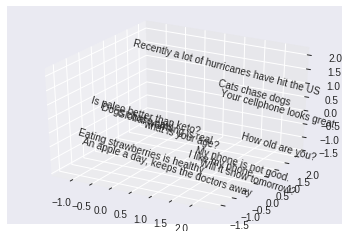

In [0]:
plot3D_sentences(example_sentences, c2v_vectors)

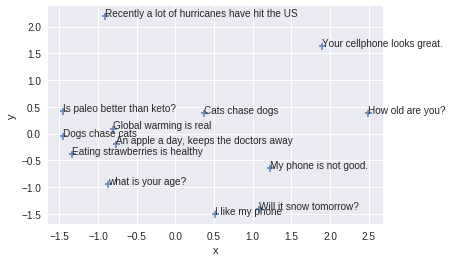

In [0]:
plot_sentences(example_sentences, c2v_vectors)

# Spacy
* Idea: Use spacy's inbuilt method for forming sentence vectors
* Pros: Simple


In [0]:
import spacy
!python3 -m spacy download en_core_web_lg
sp = spacy.load('en_core_web_lg') 

    100% |████████████████████████████████| 852.3MB 58.2MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
spacy_sentences = [sp(sentence) for sentence in example_sentences]

scores = [sp("i like my cell phone").similarity(sp_sent) for sp_sent in spacy_sentences]
ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)], reverse = True)
ranked_candidates = [example_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
ranked_candidates

['I please where I go', 'I go where I please', 'I go wherever i want']

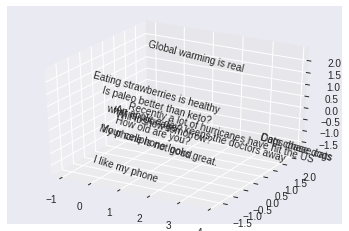

In [0]:
plot3D_sentences(example_sentences, [spacy_sentence.vector for spacy_sentence in spacy_sentences])

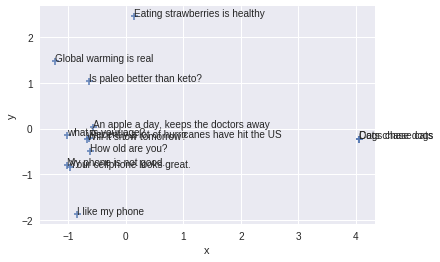

In [0]:
plot_sentences(example_sentences, [spacy_sentence.vector for spacy_sentence in spacy_sentences])

# Universal Encoder
* Idea: Sentence in -> Fixed-size Vector out (520 dimensions)
* Pros: Regardless of the number of words in the sentence, a single vector is given back
* Cons:  Compute Intensive

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)

W0313 12:14:57.619049 140111656826752 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [0]:
def universal_sentence(sentences):
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    vectors = session.run(embed(sentences))
    return vectors

In [0]:
uni_vectors = universal_sentence(example_sentences)

In [0]:
most_similar(universal_sentence(["i like my cell phone"]), uni_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

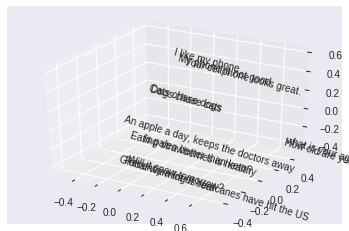

In [0]:
plot3D_sentences(example_sentences, uni_vectors)

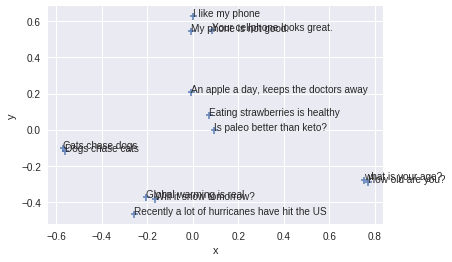

In [0]:
plot_sentences(example_sentences, uni_vectors)

# BERT as a Sentence Vector

* Method:   selects the output of the last step.  Unroll the sentence according to the time step of the word, input the vector representation of each word into a recurrent neural network(RNN), and use the output of the last time step of the RNN as the semantic representation of the sentence.  For classification tasks, the first vector (corresponding to [CLS]) is used as as the "sentence vector". Note that this only makes sense because the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
* Pros: preserves word order
* Cons: If the sentence is too long, the output of the last step does not accurately express the semantics of the sentence.


In [0]:
!pip3 install pytorch_pretrained_bert

from pytorch_pretrained_bert import BertTokenizer
tokeniser = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)

from pytorch_pretrained_bert import BertModel
bert = BertModel.from_pretrained('bert-large-uncased')

import torch

    100% |████████████████████████████████| 122kB 6.0MB/s 
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


100%|██████████| 1248501532/1248501532 [00:31<00:00, 39715435.66B/s]


In [0]:
def sentence_bert(sentence, model):
  tokenised_sentence = ["[CLS]"] + tokeniser.tokenize(sentence) +  ["[SEP]"]
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = model(tokens_tensor, segments_tensor)
  sent_vector = encoded_layers[0][-1][0]
  return sent_vector.detach().numpy()

def sentences_bert(sentences):
  return [sentence_bert(sentence, bert) for sentence in sentences]

In [0]:
bert_vectors = sentences_bert(example_sentences)

In [0]:
most_similar(sentence_bert("i like my cell phone", bert), bert_vectors)

['I please where I go', 'I go where I please', 'I go wherever i want']

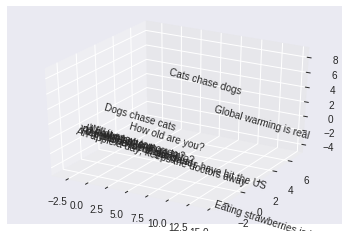

In [0]:
plot3D_sentences(example_sentences, bert_vectors)

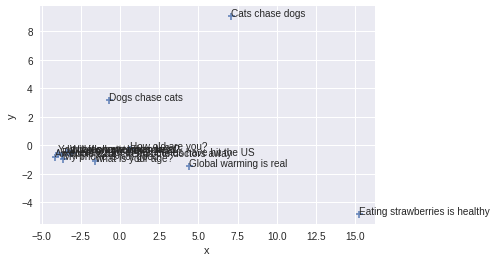

In [0]:
plot_sentences(example_sentences, bert_vectors)

# Stacked Embeddings (Char2Vec + Universal Encoder + BERT)

In [0]:
import numpy as np

def combine(vectors):
  return np.concatenate(vectors)

In [0]:
combo_vectors = [combine([a,b,c]) for a,b,c in zip(c2v_vectors, uni_vectors, bert_vectors)]

In [0]:
test_sentence = "i like my cell phone"
most_similar(combine([char2vec([test_sentence])[0],universal_sentence([test_sentence])[0], sentence_bert(test_sentence, bert)]), combo_vectors)

['I like my phone', 'My phone is not good.', 'Will it snow tomorrow?']

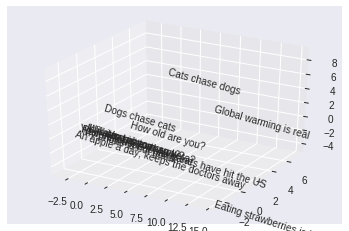

In [0]:
plot3D_sentences(example_sentences, combo_vectors)

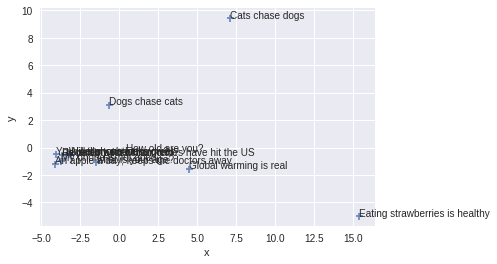

In [0]:
plot_sentences(example_sentences, combo_vectors)

# Comparing Word Vectors

# Word Mover Distance (WMD) 
* method: simple. rather than creating a single sentence vector, wmd compares each word's vector to the closest in the other sentence.  The total distances of all word vectors are taken as the distance between the two sentences
* pros: this method will account for things like mulitmodal distributions, which is often lost with methods like  averaging 
* cons: doesn't preserve word order


![alt text](https://raw.github.com/RaRe-Technologies/movie-plots-by-genre/master/ipynb_with_output/images/wmd_gelato.png)

## Word2Vec

In [1]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

--2019-03-14 13:58:36--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.104.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.104.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  74.3MB/s    in 19s     

2019-03-14 13:58:55 (83.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
def most_similar_wmd(sentence, other_sentences):
  scores = [w2v.wmdistance(sentence.lower().split(), other_sentence.lower().split()) for other_sentence in other_sentences]
  ranked_candidates_idx = sorted([(score,idx) for idx,score in enumerate(scores)])
  ranked_candidates = [other_sentences[idx] for _,idx in ranked_candidates_idx[:3]]
  return ranked_candidates

In [0]:
most_similar_wmd("i like my cell phone",example_sentences)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

# Combining Word Vectors

# Mean Pooling
Cons: The use of weighted averaging is not accurate and does not adequately express the impact of each word on sentence semantics.

In [0]:
import numpy as np

def mean_vectors(vectors, weights = None):
  return np.average(vectors, axis=0, weights = weights)

# (Tf-Idf) Weighted Average of Word Vectors

In [0]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
    
tfidf = TfidfVectorizer()
importance = tfidf.fit_transform(example_sentences) 
feature_names = tfidf.get_feature_names()
tfs = {feature_names[col] : importance[0, col]  for col in importance.nonzero()[1]}

def tfidf_weights(tokens, weights):
  ws = [0.0001 for _ in range(len(tokens))]
  for i,token in enumerate(tokens):
    if token in weights:
      w = weights[token]
      if w > 0:
        ws[i] = w
  return ws

In [0]:
from gensim.utils import tokenize

test_sentence = "i like my cell phone"
example_tokens = [token for token in tokenize(test_sentence)]
example_weights = tfidf_weights(example_tokens, tfs)
print(example_weights)
' '.join([example_token.upper()  if tfidf_weight > .5 else example_token for example_token,tfidf_weight in zip(example_tokens,example_weights)])

[0.0001, 0.6340628633768814, 0.5467925956367323, 0.0001, 0.5467925956367323]


'i LIKE MY cell PHONE'

## BERT

In [0]:
def convert_to_bert(sentence, model):
  tokenised_sentence = tokeniser.tokenize(sentence)
  tokens_tensor = torch.tensor([tokeniser.convert_tokens_to_ids(tokenised_sentence)])
  segments_tensor = torch.tensor([[0 for _ in range(len(tokenised_sentence))]])
  encoded_layers, _ = model(tokens_tensor, segments_tensor)
  bert_vectors = encoded_layers[0][-1]
  return bert_vectors.detach().numpy()

In [0]:
mean_bert_vectors = [mean_vectors(convert_to_bert(sentence, bert)) for sentence in example_sentences]
w_mean_bert_vectors = [mean_vectors(convert_to_bert(sentence, bert), tfidf_weights(tokeniser.tokenize(sentence), tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_bert(test_sentence, bert)), mean_bert_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

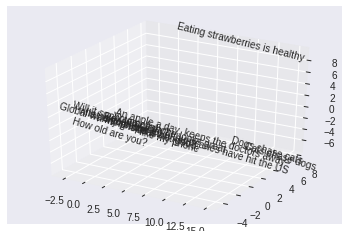

In [0]:
plot3D_sentences(example_sentences, mean_bert_vectors)

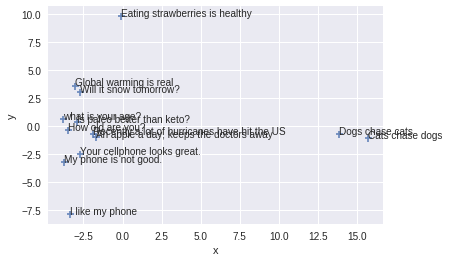

In [0]:
plot_sentences(example_sentences, mean_bert_vectors)

In [0]:
most_similar(mean_vectors(convert_to_bert(test_sentence, bert), tfidf_weights(tokeniser.tokenize(test_sentence), tfs)), w_mean_bert_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

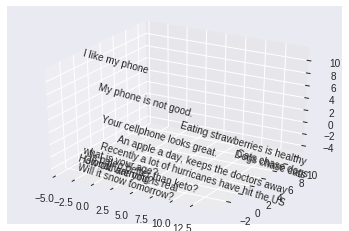

In [0]:
plot3D_sentences(example_sentences, w_mean_bert_vectors)

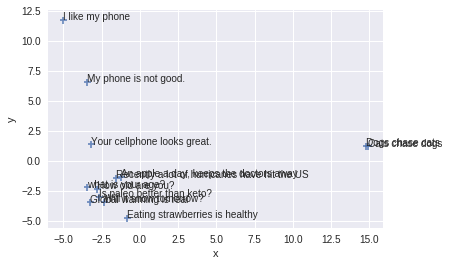

In [0]:
plot_sentences(example_sentences, w_mean_bert_vectors)

## ELMO

In [0]:
!pip3 install allennlp
from allennlp.commands.elmo import ElmoEmbedder
elmo = ElmoEmbedder()

    100% |████████████████████████████████| 5.6MB 1.0MB/s 
    100% |████████████████████████████████| 133kB 33.1MB/s 
    100% |████████████████████████████████| 1.5MB 15.8MB/s 
    100% |████████████████████████████████| 51kB 21.0MB/s 
    100% |████████████████████████████████| 552kB 25.8MB/s 
    100% |████████████████████████████████| 245kB 30.2MB/s 
    100% |████████████████████████████████| 512kB 18.1MB/s 
    100% |████████████████████████████████| 12.6MB 2.1MB/s 
    100% |████████████████████████████████| 51kB 21.4MB/s 
    100% |████████████████████████████████| 4.5MB 8.3MB/s 
    100% |████████████████████████████████| 5.3MB 6.9MB/s 
    100% |████████████████████████████████| 51kB 20.7MB/s 
    100% |████████████████████████████████| 51kB 21.1MB/s 
    100% |████████████████████████████████| 61kB 23.8MB/s 
    100% |████████████████████████████████| 2.3MB 13.2MB/s 
    100% |████████████████████████████████| 143kB 34.3MB/s 
    100% |████████████████████████████████| 92kB

100%|██████████| 374434792/374434792 [00:29<00:00, 12675933.06B/s]


In [0]:
def convert_to_elmo(sentence, model):
  return elmo.embed_sentence(sentence.split())[-1]

In [0]:
mean_elmo_vectors = [mean_vectors(convert_to_elmo(sentence, elmo)) for sentence in example_sentences]
w_mean_elmo_vectors = [mean_vectors(convert_to_elmo(sentence, elmo), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_elmo(test_sentence, elmo)), mean_elmo_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

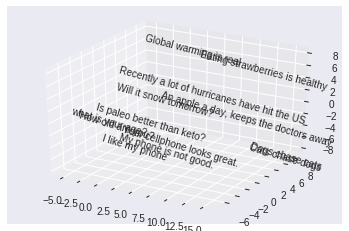

In [0]:
plot3D_sentences(example_sentences, mean_elmo_vectors)

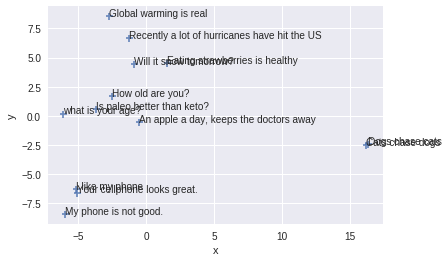

In [0]:
plot_sentences(example_sentences, mean_elmo_vectors)

In [0]:
most_similar(mean_vectors(convert_to_elmo(test_sentence, elmo), example_weights), w_mean_elmo_vectors)

['I like my phone', 'Your cellphone looks great.', 'what is your age?']

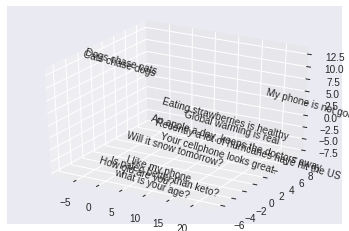

In [0]:
plot3D_sentences(example_sentences, w_mean_elmo_vectors)

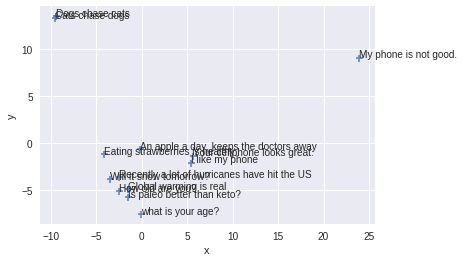

In [0]:
plot_sentences(example_sentences, w_mean_elmo_vectors)

## FastText & GloVe

In [0]:
!pip3 install mxnet
!pip3 install gluonnlp

import gluonnlp
fasttext = gluonnlp.embedding.create('fasttext', source='wiki.simple')
glove = gluonnlp.embedding.create('glove', source='glove.6B.300d') 

    100% |████████████████████████████████| 28.4MB 1.3MB/s 
    100% |████████████████████████████████| 61kB 20.5MB/s 
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4


    100% |████████████████████████████████| 194kB 8.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/19/c4/f4/70dc14c8b01db12cd4f88c6f71128bb88de545a7690e192ce0
Successfully built gluonnlp
Embedding file wiki.simple.npz is not found. Downloading from Gluon Repository. This may take some time.
Embedding file glove.6B.300d.npz is not found. Downloading from Gluon Repository. This may take some time.


In [0]:
def convert_to_ft_glove(sentence,model):
  return [model[word].asnumpy() for word in sentence.split()]

In [0]:
mean_fasttext_vectors = [mean_vectors(convert_to_ft_glove(sentence, fasttext)) for sentence in example_sentences]
w_mean_fasttext_vectors = [mean_vectors(convert_to_ft_glove(sentence, fasttext), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

mean_glove_vectors = [mean_vectors(convert_to_ft_glove(sentence, glove)) for sentence in example_sentences]
w_mean_glove_vectors = [mean_vectors(convert_to_ft_glove(sentence, glove), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, fasttext)), mean_fasttext_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

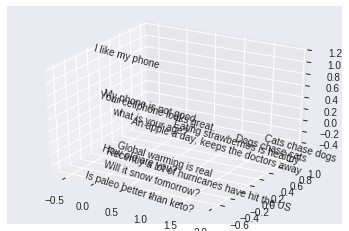

In [0]:
plot3D_sentences(example_sentences, mean_fasttext_vectors)

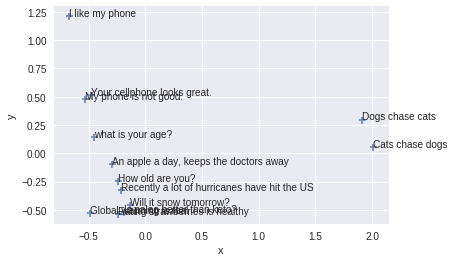

In [0]:
plot_sentences(example_sentences, mean_fasttext_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, fasttext),example_weights), w_mean_fasttext_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

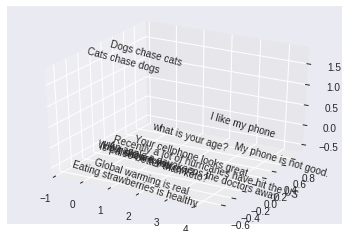

In [0]:
plot3D_sentences(example_sentences, w_mean_fasttext_vectors)

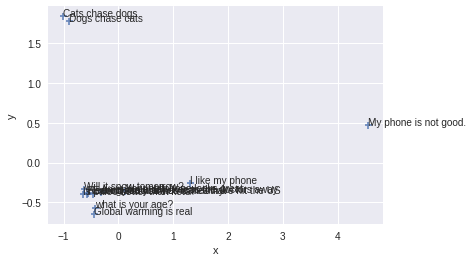

In [0]:
plot_sentences(example_sentences, w_mean_fasttext_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, glove)), mean_glove_vectors)

['I like my phone', 'My phone is not good.', 'what is your age?']

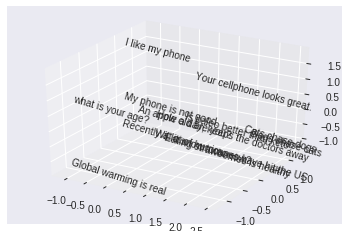

In [0]:
plot3D_sentences(example_sentences, mean_glove_vectors)

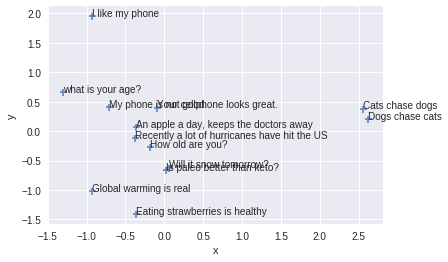

In [0]:
plot_sentences(example_sentences, mean_glove_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ft_glove(test_sentence, glove), example_weights), w_mean_glove_vectors)

['I like my phone', 'what is your age?', 'My phone is not good.']

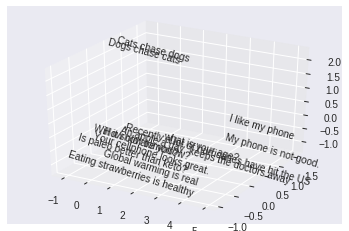

In [0]:
plot3D_sentences(example_sentences, w_mean_glove_vectors)

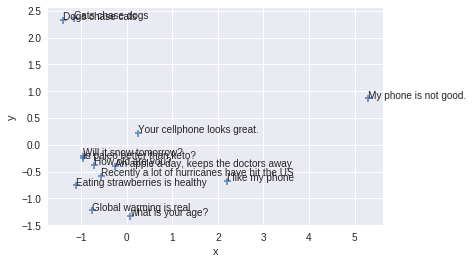

In [0]:
plot_sentences(example_sentences, w_mean_glove_vectors)

## NumberBatch (using Gensim)

In [0]:
!wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
!gunzip numberbatch-17.06.txt.gz

--2019-03-14 00:16:52--  https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-17.06.txt.gz
Resolving conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)... 52.216.112.148
Connecting to conceptnet.s3.amazonaws.com (conceptnet.s3.amazonaws.com)|52.216.112.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1193268949 (1.1G) [text/plain]
Saving to: ‘numberbatch-17.06.txt.gz’

numberbatch-17.06.t 100%[===================>]   1.11G  48.6MB/s    in 24s     

2019-03-14 00:17:16 (47.8 MB/s) - ‘numberbatch-17.06.txt.gz’ saved [1193268949/1193268949]



In [0]:
from gensim.models.keyedvectors import KeyedVectors
numberbatch = KeyedVectors.load_word2vec_format("numberbatch-17.06.txt", binary=False)

In [0]:
from gensim.utils import tokenize

def convert_to_numberbatch(sentence, language = "en"):
  tokens = [token.lower().replace(' ','_') for token in tokenize(sentence)]
  return [numberbatch[f"/c/{language}/{token}"] for token in tokens]

In [0]:
mean_numberbatch_vectors = [mean_vectors(convert_to_numberbatch(sentence)) for sentence in example_sentences]
w_mean_numberbatch_vectors = [mean_vectors(convert_to_numberbatch(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_numberbatch(test_sentence)), mean_numberbatch_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

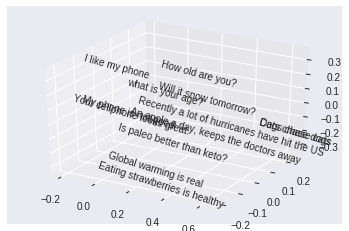

In [0]:
plot3D_sentences(example_sentences, mean_numberbatch_vectors)

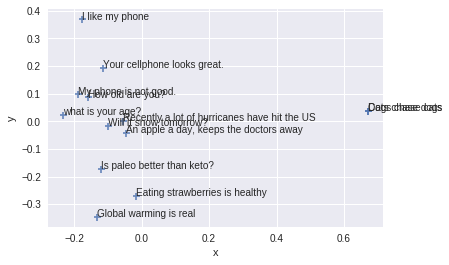

In [0]:
plot_sentences(example_sentences, mean_numberbatch_vectors)

In [0]:
most_similar(mean_vectors(convert_to_numberbatch(test_sentence), example_weights), w_mean_numberbatch_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

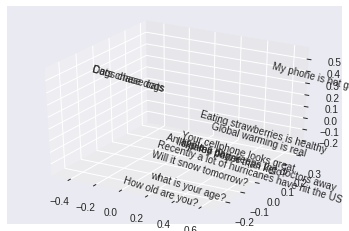

In [0]:
plot3D_sentences(example_sentences, w_mean_numberbatch_vectors)

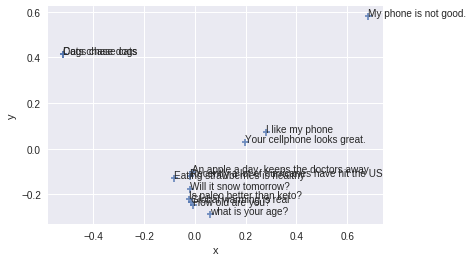

In [0]:
plot_sentences(example_sentences, w_mean_numberbatch_vectors)

## FLAIR

In [0]:
!pip3 install flair

    100% |████████████████████████████████| 81kB 4.7MB/s 
    100% |████████████████████████████████| 798kB 20.7MB/s 
    100% |████████████████████████████████| 1.0MB 13.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/70/55/6b/c12cf58209b8346f653a04f37dd8f607ab0e85a26238a23420
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Stored in directory: /root/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
Successfully built flair segtok mpld3 sqlitedict


In [0]:
from flair.embeddings import FlairEmbeddings, StackedEmbeddings, Sentence
stacked_embeddings = StackedEmbeddings([FlairEmbeddings('news-forward'), FlairEmbeddings('news-backward')])

def convert_to_flair(sentence):
  s = Sentence(sentence)
  stacked_embeddings.embed(s)
  return [token.embedding.detach().numpy() for token in s]

2019-03-12 21:50:49,000 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-forward--h2048-l1-d0.05-lr30-0.25-20/news-forward-0.4.1.pt not found in cache, downloading to /tmp/tmpq72iy5l2


100%|██████████| 73034624/73034624 [00:05<00:00, 13044868.66B/s]

2019-03-12 21:50:55,310 copying /tmp/tmpq72iy5l2 to cache at /root/.flair/embeddings/news-forward-0.4.1.pt


2019-03-12 21:50:55,676 removing temp file /tmp/tmpq72iy5l2
2019-03-12 21:50:56,709 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-backward--h2048-l1-d0.05-lr30-0.25-20/news-backward-0.4.1.pt not found in cache, downloading to /tmp/tmpulum5i5u


100%|██████████| 73034575/73034575 [00:05<00:00, 12609692.84B/s]

2019-03-12 21:51:03,223 copying /tmp/tmpulum5i5u to cache at /root/.flair/embeddings/news-backward-0.4.1.pt


2019-03-12 21:51:03,530 removing temp file /tmp/tmpulum5i5u


In [0]:
mean_flair_vectors = [mean_vectors(convert_to_flair(sentence)) for sentence in example_sentences]
w_mean_flair_vectors = [mean_vectors(convert_to_flair(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_flair(test_sentence)), mean_flair_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

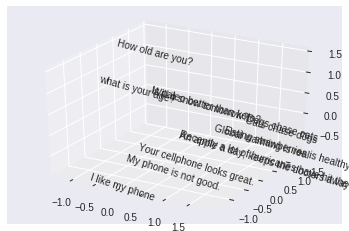

In [0]:
plot3D_sentences(example_sentences, mean_flair_vectors)

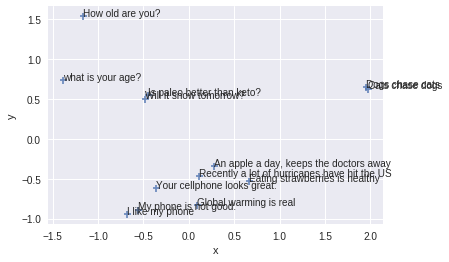

In [0]:
plot_sentences(example_sentences, mean_flair_vectors)

In [0]:
most_similar(mean_vectors(convert_to_flair(test_sentence), example_weights), w_mean_flair_vectors)

['I like my phone', 'Your cellphone looks great.', 'My phone is not good.']

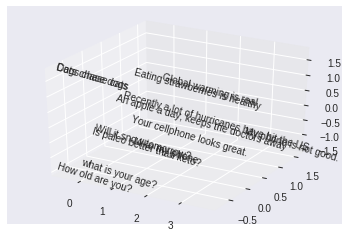

In [0]:
plot3D_sentences(example_sentences, w_mean_flair_vectors)

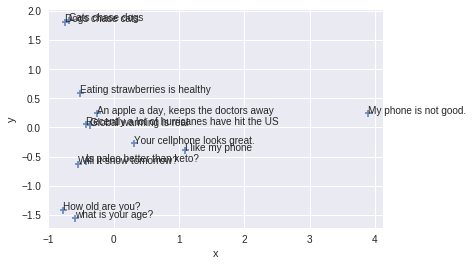

In [0]:
plot_sentences(example_sentences, w_mean_flair_vectors)

## Ensemble Embeddings (Flair + Glove + BERT + ELMo)

In [0]:
!pip3 install flair
!pip3 install allennlp

In [0]:
from flair.embeddings import FlairEmbeddings, BertEmbeddings, StackedEmbeddings, ELMoEmbeddings, WordEmbeddings, Sentence

flair_forward_embedding = FlairEmbeddings('multi-forward')
flair_backward_embedding = FlairEmbeddings('multi-backward')
bert_embedding = BertEmbeddings('bert-base-multilingual-cased')
elmo_embedding = ELMoEmbeddings()
glove_embedding = WordEmbeddings('glove')

ensemble_embeddings = StackedEmbeddings(embeddings=[flair_forward_embedding, flair_backward_embedding, bert_embedding, elmo_embedding, glove_embedding])

def convert_to_ensemble(sentence):
  s = Sentence(sentence)
  ensemble_embeddings.embed(s)
  return [token.embedding.detach().numpy() for token in s]

2019-03-12 21:57:12,750 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpk6exd2bk


100%|██████████| 160000128/160000128 [00:11<00:00, 14440954.79B/s]

2019-03-12 21:57:24,556 copying /tmp/tmpk6exd2bk to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2019-03-12 21:57:25,533 removing temp file /tmp/tmpk6exd2bk
2019-03-12 21:57:26,139 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmpzyubhjli


100%|██████████| 21494764/21494764 [00:02<00:00, 8189659.01B/s]

2019-03-12 21:57:29,457 copying /tmp/tmpzyubhjli to cache at /root/.flair/embeddings/glove.gensim


2019-03-12 21:57:29,542 removing temp file /tmp/tmpzyubhjli


In [0]:
mean_ensemble_vectors = [mean_vectors(convert_to_ensemble(sentence)) for sentence in example_sentences]
w_mean_ensemble_vectors = [mean_vectors(convert_to_ensemble(sentence), tfidf_weights([token for token in tokenize(sentence)], tfs)) for sentence in example_sentences]

In [0]:
most_similar(mean_vectors(convert_to_ensemble(test_sentence)), mean_ensemble_vectors)

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.']

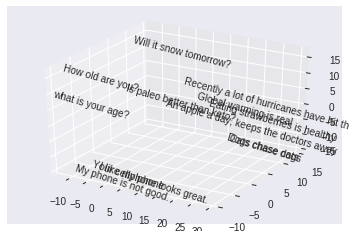

In [0]:
plot3D_sentences(example_sentences, mean_ensemble_vectors)

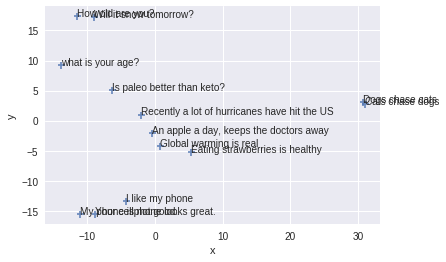

In [0]:
plot_sentences(example_sentences, mean_ensemble_vectors)

In [0]:
most_similar(mean_vectors(convert_to_ensemble(test_sentence), example_weights), w_mean_ensemble_vectors)

['I like my phone',
 'Your cellphone looks great.',
 'An apple a day, keeps the doctors away']

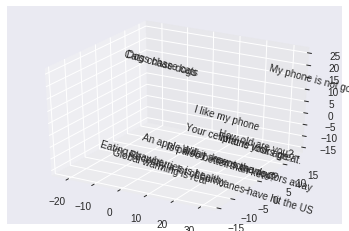

In [0]:
plot3D_sentences(example_sentences, w_mean_ensemble_vectors)

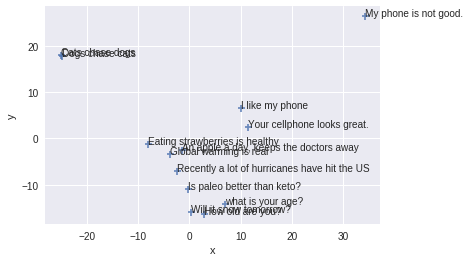

In [0]:
plot_sentences(example_sentences, w_mean_ensemble_vectors)

# RNN pooling 
* Method: use the last embedding for an RNN as the combine embedding for all the words before it
* Pros: convenient
* Cons: unreliable results

In [0]:
!pip3 install flair
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings, Sentence

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

def rnn_pool(sentence):
  s = Sentence(sentence)
  document_embeddings.embed(s)
  return s.get_embedding().detach().numpy()

In [0]:
rnn_vectors = [rnn_pool(sentence) for sentence in example_sentences]

In [0]:
most_similar(rnn_pool("i like my cell phone"), rnn_vectors)

['I like my phone', 'Is paleo better than keto?', 'what is your age?']

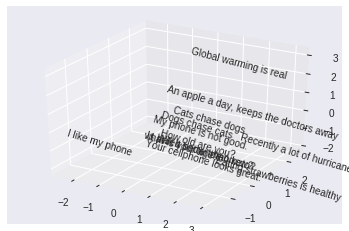

In [0]:
plot3D_sentences(example_sentences, rnn_vectors)

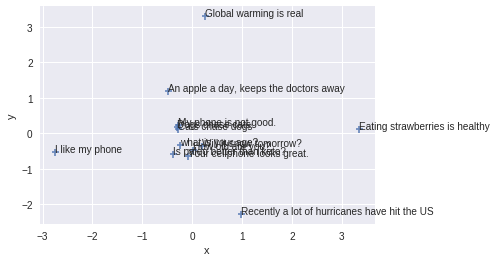

In [0]:
plot_sentences(example_sentences,rnn_vectors)

# CNN pooling
* Method: Convolution(CNN) and maximum pooling(MaxPooling) on the matrix of all the word vectors of the sentence, using the final result to represent the semantics of the sentence.
* Cons: Many useful word meanings may be lost

# Random Projections

In [0]:
#from gensim import models
#vectors = [[(1,0),(2,0),(3,0),(4,0),(5,0)],[(1,0),(2,0),(3,0),(4,0),(5,0)],[(1,0),(2,0),(3,0),(4,0),(5,0)]]
#model = models.RpModel(vectors, num_topics=2)
#[v for v in model[vectors]]

# Stacked Autoencoders

# A Structured Self-attentive Sentence Embedding

In [0]:
#!pip3 install mxnet
#!pip3 install gluonnlp
import os, json, zipfile, time, itertools
import numpy as np
import mxnet as mx
import multiprocessing as mp
import gluonnlp as nlp

from mxnet import  autograd, gluon, nd, init
from mxnet.gluon import nn, rnn

from sklearn.metrics import accuracy_score, f1_score
np.random.seed(2018)
mx.random.seed(2018)

def try_gpu():
    try:
        ctx = mx.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mx.cpu()
    return ctx

In [0]:
data_url = 'http://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/dataset/yelp_review_subset-167bb781.zip'
zip_path = mx.gluon.utils.download(data_url)

# unzip the zip file.
zip_file = zipfile.ZipFile(zip_path)
json_path = zip_file.extract(zip_file.namelist()[0])

## load json data.
with open(json_path, 'r', encoding='utf-8') as fr:
    data = json.load(fr)

# create a list of review a label paris.
dataset = [[text, int(label)] for text, label in zip(data['texts'], data['labels'])]

# randomly divide one percent from the training set as a verification set.
train_dataset, valid_dataset = nlp.data.train_valid_split(dataset, 0.01)
len(train_dataset), len(valid_dataset)

In [0]:
# tokenizer takes as input a string and outputs a list of tokens.
tokenizer = nlp.data.SpacyTokenizer('en')

# length_clip takes as input a list and outputs a list with maximum length 100.
length_clip = nlp.data.ClipSequence(100)

def preprocess(x):

    # convert the number of stars 1, 2, 3, 4, 5 to zero-based index, 0, 1, 2, 3, 4
    data, label = x[0], x[1]-1

    # clip the length of review words
    data = length_clip(tokenizer(data))
    return data, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()

    with mp.Pool() as pool:
        # Each sample is processed in an asynchronous manner.
        dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
        lengths = gluon.data.SimpleDataset(pool.map(get_length, dataset))
    end = time.time()

    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
valid_dataset, valid_data_lengths = preprocess_dataset(valid_dataset)

In [0]:
# create vocab
train_seqs = [sample[0] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))

vocab = nlp.Vocab(counter, max_size=10000)

# load pre-trained embedding,Glove
embedding_weights = nlp.embedding.GloVe(source='glove.6B.300d')
vocab.set_embedding(embedding_weights)
print(vocab)

def token_to_idx(x):
    return vocab[x[0]], x[1]

# A token index or a list of token indices is returned according to the vocabulary.
with mp.Pool() as pool:
    train_dataset = pool.map(token_to_idx, train_dataset)
    valid_dataset = pool.map(token_to_idx, valid_dataset)

In [0]:
batch_size = 64
bucket_num = 10
bucket_ratio = 0.5


def get_dataloader():
    # Construct the DataLoader Pad data, stack label and lengths
    batchify_fn = nlp.data.batchify.Tuple(
        nlp.data.batchify.Pad(axis=0),
        nlp.data.batchify.Stack())

    # n this example, we use a FixedBucketSampler,
    # which assigns each data sample to a fixed bucket based on its length.
    batch_sampler = nlp.data.sampler.FixedBucketSampler(
        train_data_lengths,
        batch_size=batch_size,
        num_buckets=bucket_num,
        ratio=bucket_ratio,
        shuffle=True)
    print(batch_sampler.stats())

    # train_dataloader
    train_dataloader = gluon.data.DataLoader(
        dataset=train_dataset,
        batch_sampler=batch_sampler,
        batchify_fn=batchify_fn)
    # valid_dataloader
    valid_dataloader = gluon.data.DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        batchify_fn=batchify_fn)
    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloader()

In [0]:
# custom attention layer
class SelfAttention(nn.HybridBlock):
    def __init__(self, att_unit, att_hops, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        with self.name_scope():
            self.ut_dense = nn.Dense(att_unit, activation='tanh', flatten=False)
            self.et_dense = nn.Dense(att_hops, activation=None, flatten=False)

    def hybrid_forward(self, F, x):
        # x shape: [batch_size, seq_len, embedding_width]
        # ut shape: [batch_size, seq_len, att_unit]
        ut = self.ut_dense(x)
        # et shape: [batch_size, seq_len, att_hops]
        et = self.et_dense(ut)

        # att shape: [batch_size,  att_hops, seq_len]
        att = F.softmax(F.transpose(et, axes=(0, 2, 1)), axis=-1)
        # output shape [batch_size, att_hops, embedding_width]
        output = F.batch_dot(att, x)

        return output, att

class WeightedSoftmaxCE(nn.HybridBlock):
    def __init__(self, sparse_label=True, from_logits=False,  **kwargs):
        super(WeightedSoftmaxCE, self).__init__(**kwargs)
        with self.name_scope():
            self.sparse_label = sparse_label
            self.from_logits = from_logits

    def hybrid_forward(self, F, pred, label, class_weight, depth=None):
        if self.sparse_label:
            label = F.reshape(label, shape=(-1, ))
            label = F.one_hot(label, depth)
        if not self.from_logits:
            pred = F.log_softmax(pred, -1)

        weight_label = F.broadcast_mul(label, class_weight)
        loss = -F.sum(pred * weight_label, axis=-1)

        # return F.mean(loss, axis=0, exclude=True)
        return loss
  
class SelfAttentiveBiLSTM(nn.HybridBlock):
    def __init__(self, vocab_len, embsize, nhidden, nlayers, natt_unit, natt_hops, nfc, nclass,
                 drop_prob, pool_way, prune_p=None, prune_q=None, **kwargs):
        super(SelfAttentiveBiLSTM, self).__init__(**kwargs)
        with self.name_scope():
            self.embedding_layer = nn.Embedding(vocab_len, embsize)
            self.bilstm = rnn.LSTM(nhidden, num_layers=nlayers, dropout=drop_prob, bidirectional=True)
            self.att_encoder = SelfAttention(natt_unit, natt_hops)
            self.dense = nn.Dense(nfc, activation='tanh')
            self.output_layer = nn.Dense(nclass)

            self.dense_p, self.dense_q = None, None
            if all([prune_p, prune_q]):
                self.dense_p = nn.Dense(prune_p, activation='tanh', flatten=False)
                self.dense_q = nn.Dense(prune_q, activation='tanh', flatten=False)

            self.drop_prob = drop_prob
            self.pool_way = pool_way

    def hybrid_forward(self, F, inp):
        # input_embed: [batch, len, emsize]
        inp_embed = self.embedding_layer(inp)
        h_output = self.bilstm(F.transpose(inp_embed, axes=(1, 0, 2)))
        # att_output: [batch, att_hops, emsize]
        att_output, att = self.att_encoder(F.transpose(h_output, axes=(1, 0, 2)))

        dense_input = None
        if self.pool_way == 'flatten':
            dense_input = F.Dropout(F.flatten(att_output), self.drop_prob)
        elif self.pool_way == 'mean':
            dense_input = F.Dropout(F.mean(att_output, axis=1), self.drop_prob)
        elif self.pool_way == 'prune' and all([self.dense_p, self.dense_q]):
            # p_section: [batch, att_hops, prune_p]
            p_section = self.dense_p(att_output)
            # q_section: [batch, emsize, prune_q]
            q_section = self.dense_q(F.transpose(att_output, axes=(0, 2, 1)))
            dense_input = F.Dropout(F.concat(F.flatten(p_section), F.flatten(q_section), dim=-1), self.drop_prob)

        dense_out = self.dense(dense_input)
        output = self.output_layer(F.Dropout(dense_out, self.drop_prob))

        return output, att

In [0]:
vocab_len = len(vocab)
emsize = 300   # word embedding size
nhidden = 300    # lstm hidden_dim
nlayers = 2     # lstm layers
natt_unit = 300     # the hidden_units of attenion layer
natt_hops = 2    # the channels of attention
nfc = 512
nclass = 5

drop_prob = 0.5
pool_way = 'flatten'    # # The way to handle M
prune_p = None
prune_q = None

ctx = try_gpu()

model = SelfAttentiveBiLSTM(vocab_len, emsize, nhidden, nlayers,
                            natt_unit, natt_hops, nfc, nclass,
                            drop_prob, pool_way, prune_p, prune_q)

model.initialize(init=init.Xavier(), ctx=ctx)
model.hybridize()

# Attach a pre-trained glove word vector to the embedding layer
model.embedding_layer.weight.set_data(vocab.embedding.idx_to_vec)
# fixed the layer
model.embedding_layer.collect_params().setattr('grad_req', 'null')

In [0]:
def calculate_loss(x, y, model, loss, class_weight, penal_coeff):
    pred, att = model(x)
    if loss_name == 'sce':
        l = loss(pred, y)
    elif loss_name == 'wsce':
        l = loss(pred, y, class_weight, class_weight.shape[0])

    # penalty
    diversity_penalty = nd.batch_dot(att, nd.transpose(att, axes=(0, 2, 1))
                        ) - nd.eye(att.shape[1], ctx=att.context)
    l = l + penal_coeff * diversity_penalty.norm(axis=(1, 2))

    return pred, l

def one_epoch(data_iter, model, loss, trainer, ctx, is_train, epoch,
              penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    loss_val = 0.
    total_pred = []
    total_true = []
    n_batch = 0

    for batch_x, batch_y in data_iter:
        batch_x = batch_x.as_in_context(ctx)
        batch_y = batch_y.as_in_context(ctx)

        if is_train:
            with autograd.record():
                batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

            # backward calculate
            l.backward()

            # clip gradient
            clip_params = [p.data() for p in model.collect_params().values()]
            if clip is not None:
                norm = nd.array([0.0], ctx)
                for param in clip_params:
                    if param.grad is not None:
                        norm += (param.grad ** 2).sum()
                norm = norm.sqrt().asscalar()
                if norm > clip:
                    for param in clip_params:
                        if param.grad is not None:
                            param.grad[:] *= clip / norm

            # update parmas
            trainer.step(batch_x.shape[0])

        else:
            batch_pred, l = calculate_loss(batch_x, batch_y, model, loss, class_weight, penal_coeff)

        # keep result for metric
        batch_pred = nd.argmax(nd.softmax(batch_pred, axis=1), axis=1).asnumpy()
        batch_true = np.reshape(batch_y.asnumpy(), (-1, ))
        total_pred.extend(batch_pred.tolist())
        total_true.extend(batch_true.tolist())

        batch_loss = l.mean().asscalar()

        n_batch += 1
        loss_val += batch_loss

        # check the result of traing phase
        if is_train and n_batch % 400 == 0:
            print('epoch %d, batch %d, batch_train_loss %.4f, batch_train_acc %.3f' %
                  (epoch, n_batch, batch_loss, accuracy_score(batch_true, batch_pred)))

    # metric
    F1 = f1_score(np.array(total_true), np.array(total_pred), average='weighted')
    acc = accuracy_score(np.array(total_true), np.array(total_pred))
    loss_val /= n_batch

    if is_train:
        print('epoch %d, learning_rate %.5f \n\t train_loss %.4f, acc_train %.3f, F1_train %.3f, ' %
              (epoch, trainer.learning_rate, loss_val, acc, F1))
        # declay lr
        if epoch % 2 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.9)
    else:
        print('\t valid_loss %.4f, acc_valid %.3f, F1_valid %.3f, ' % (loss_val, acc, F1))

def train_valid(data_iter_train, data_iter_valid, model, loss, trainer, ctx, nepochs,
                penal_coeff=0.0, clip=None, class_weight=None, loss_name='wsce'):

    for epoch in range(1, nepochs+1):
        start = time.time()
        # train
        is_train = True
        one_epoch(data_iter_train, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)

        # valid
        is_train = False
        one_epoch(data_iter_valid, model, loss, trainer, ctx, is_train,
                  epoch, penal_coeff, clip, class_weight, loss_name)
        end = time.time()
        print('time %.2f sec' % (end-start))
        print("*"*100)


In [0]:
class_weight = None
loss_name = 'wsce'
optim = 'adam'
lr = 0.001
penal_coeff = 0.1
clip = 0.5
nepochs = 4

trainer = gluon.Trainer(model.collect_params(), optim, {'learning_rate': lr})

if loss_name == 'sce':
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
elif loss_name == 'wsce':
    loss = WeightedSoftmaxCE()
    # the value of class_weight is obtained by counting data in advance. It can be seen as a hyperparameter.
    class_weight = nd.array([3.0, 5.3, 4.0, 2.0, 1.0], ctx=ctx)

In [0]:
# train and valid
train_valid(train_dataloader, valid_dataloader, model, loss, trainer, ctx, nepochs,
            penal_coeff=penal_coeff, clip=clip, class_weight=class_weight, loss_name=loss_name)

In [0]:
input_ar = nd.array(vocab["i like my cell phone".split()], ctx=ctx).reshape((1, -1))
pred, att = model(input_ar)

label = np.argmax(nd.softmax(pred, axis=1).asnumpy(), axis=1) + 1
print(label)
print(att)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.squeeze(att.asnumpy(), 0).shape
plt.figure(figsize=(8,1))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(np.squeeze(att.asnumpy(), 0), cmap=cmap, annot=True,
            xticklabels="i like my cell phone".split(), yticklabels=['att0', 'att1'])
plt.show()

# Triplets of Sentence Vectors (Semantic Net Vectors)
Allen NLP's Open Information Extraction to identify triplet.  Then embed

# Benchmarking

In [3]:
!wget https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/antimetabole.csv

--2019-03-14 14:01:08--  https://raw.githubusercontent.com/mohammedterry/NLP_for_ML/master/antimetabole.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003 (2.0K) [text/plain]
Saving to: ‘antimetabole.csv’

antimetabole.csv    100%[===================>]   1.96K  --.-KB/s    in 0s      

2019-03-14 14:01:08 (31.0 MB/s) - ‘antimetabole.csv’ saved [2003/2003]



In [4]:
import pandas as pd
testbench = pd.read_csv("antimetabole.csv")
testbench

,sentence,antimetabole,rephrase
0,I go where I please,I please where I go,I go wherever i want
1,Ask not what your country can do for you,ask what you can do for your country,don't ask what you can get out of your country
2,We do what we like,we like what we do,we do whatever we desire
3,be with the one you love,love the one you’re with,stay with your loved one
4,Fair is foul,foul is Fair,fairness sometimes seems unpleasant
5,the beginning of the end,the end of the beginning,the end has begun
6,People forget all those things they don't want...,people remember everything they don't want to ...,if someone doesn't want to remember it they wi...
7,describe the beautiful as ugly,describe the ugly as beautiful,depicting a beautiful thing as being unattractive
8,confuse the true with the false,confuse the false with the true,mistaking truth with falsehood
9,misery from power,power from misery,being in charge is not all fun


In [0]:
def correct(vector_anti_vector_sim_vector):
  vector,anti_vector,sim_vector = vector_anti_vector_sim_vector
  from scipy.spatial.distance import cosine
  return cosine(vector,sim_vector) < cosine(vector,anti_vector)

def test(batch_vectors):
  return sum([correct(batch_vectors[i]) for i in range(len(batch_vectors))])

def batch(batch_vectoriser, dataframe, batch_size = 3):
  sentences = []
  for i in range(len(dataframe)):
    sentences.extend(dataframe.iloc[i].tolist())
  vectors = batch_vectoriser(sentences)
  return [vectors[i:i+3] for i in range(0,len(vectors),3)]

In [13]:
score = 0
for i in range(len(testbench)):
  xy = testbench.iloc[i].tolist()
  x,yy = xy[0],xy[1:]
  y = yy[-1]
  y_hat = most_similar_wmd(x,yy)[0]
  if y == y_hat:
    score += 1
score

1

In [0]:
test(batch(bow_vectoriser,testbench))

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


1

In [0]:
test(batch(universal_sentence,testbench))

4

In [0]:
test(batch(sentences_bert, testbench))

6

In [0]:
test(batch(char2vec,testbench))

7

https://github.com/facebookresearch/SentEval